In this notebook, we will train an XGBoost ML model to predict Vegetation Optical Depth at C-band (C-VOD) given a set of features from a land surface model and satellite observations (Leaf Area Index; LAI). This training database includes both dynamic features (*e.g.* fuel moisture in dead vegetation, soil temperature) and static features (*e.g.* vegetation cover/type).

In [1]:
# Import external librairies
from anemoi.datasets import open_dataset

import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature  
from cartopy.io.shapereader import natural_earth
from shapely.geometry import Point

import shap

/lus/h2resw01/hpcperm/masg/venvs/mlenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '.'
dataname_train = 'training_sample-201901-201903-8d_9km.zarr'
dataname_test = 'test_sample-202101-8d_9km.zarr'

In [3]:
# Read data
target = ['vod_c']
features = ['total_fuel_load', 'dfmc_foliage', 'dfmc_wood', 'lai', 'swvl1', 'swvl4', 'stl1', '2d', '2t', 'ssrd', 'tvh', 'tvl', 'cvh', 'cvl']
varnames = features + target
ds_train = open_dataset(f'{path}/{dataname}', start="2019-01-01", end="2019-03-31", select=varnames)
ds_test = open_dataset(f'{path}/{dataname}', start="2021-01-01", end="2021-01-31", select=varnames)

print(f"Training data shape is {ds_train.shape}")
print(f"Test data shape is {ds_test.shape}")

train_data = ds_train[:]  # (time, variables, ensemble, space)
test_data = ds_test[:]    # (time, variables, ensemble, space)

train_time_metadata = ds_train.dates
test_time_metadata = ds_test.dates

Training data shape is (12, 15, 1, 6599680)
Test data shape is (4, 15, 1, 6599680)


In [8]:
# Remove NaN values
def reshape_and_filter(data, time_metadata):
    """
    Reshapes 4D data into 2D and removes rows with NaN values.
    """
    time, vars_, ensemble, space = data.shape
    reshaped = data.transpose(0, 2, 3, 1).reshape(-1, vars_)
    time_mapping = np.repeat(time_metadata, ensemble * space)
    spatial_indices = np.tile(np.arange(space), time * ensemble)

    # Filter valid rows
    valid_mask = ~np.isnan(reshaped).any(axis=1)
    return reshaped[valid_mask], time_mapping[valid_mask], spatial_indices[valid_mask]

# Reshape and filter data
train_data_clean, retained_time_mapping_train, retained_spatial_indices_train = reshape_and_filter(train_data, train_time_metadata)
test_data_clean, retained_time_mapping_test, retained_spatial_indices_test = reshape_and_filter(test_data, test_time_metadata)

# Ensure no NaNs remain
assert not np.isnan(X_train).any() and not np.isnan(y_train_flat).any(), "NaNs found in training data!"
assert not np.isnan(X_test).any() and not np.isnan(y_test_flat).any(), "NaNs found in testing data!"

In [9]:
# Split into features (X) and targets (y)
X_train = train_data_clean[:, :-1]
y_train_flat = train_data_clean[:, -1]  # Flattened target for training
X_test = test_data_clean[:, :-1]
y_test_flat = test_data_clean[:, -1]  # Flattened target for testing

In [10]:
# Define feature names and prepare DMatrix (GPU usage)
dtrain = xgb.DMatrix(X_train, label=y_train_flat, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test_flat, feature_names=features)

In [13]:
# Define the XGBoost params
params = {
        'objective': 'reg:squarederror',
        #'learning_rate': 0.03,
        #'max_depth': 4,
        #'subsample': 0.7,
        #'colsample_bytree': 0.7,
        #'min_child_weight': 8,
        #'gamma': 5,
        #'lambda': 3.0,
        #'alpha': 1.0,
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }

num_boost_round = 2000
early_stopping_rounds = 100
evals_result = {}

In [14]:
# Train the XGBoost model
model = xgb.train(
    params, dtrain, num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    evals_result=evals_result, early_stopping_rounds=early_stopping_rounds,
    verbose_eval=10
)

[0]	train-rmse:0.23374	eval-rmse:0.23792
[10]	train-rmse:0.14252	eval-rmse:0.14597
[20]	train-rmse:0.13771	eval-rmse:0.14182
[30]	train-rmse:0.13511	eval-rmse:0.13992
[40]	train-rmse:0.13324	eval-rmse:0.13872
[50]	train-rmse:0.13185	eval-rmse:0.13777
[60]	train-rmse:0.13075	eval-rmse:0.13700
[70]	train-rmse:0.12992	eval-rmse:0.13655
[80]	train-rmse:0.12910	eval-rmse:0.13614
[90]	train-rmse:0.12848	eval-rmse:0.13584
[100]	train-rmse:0.12774	eval-rmse:0.13542
[110]	train-rmse:0.12710	eval-rmse:0.13511
[120]	train-rmse:0.12656	eval-rmse:0.13486
[130]	train-rmse:0.12604	eval-rmse:0.13461
[140]	train-rmse:0.12558	eval-rmse:0.13445
[150]	train-rmse:0.12513	eval-rmse:0.13428
[160]	train-rmse:0.12470	eval-rmse:0.13410
[170]	train-rmse:0.12431	eval-rmse:0.13397
[180]	train-rmse:0.12405	eval-rmse:0.13389
[190]	train-rmse:0.12373	eval-rmse:0.13383
[200]	train-rmse:0.12344	eval-rmse:0.13374
[210]	train-rmse:0.12307	eval-rmse:0.13357
[220]	train-rmse:0.12281	eval-rmse:0.13350
[230]	train-rmse:0.122

Stopping early: RMSE decrease < 0.01 at tree 27


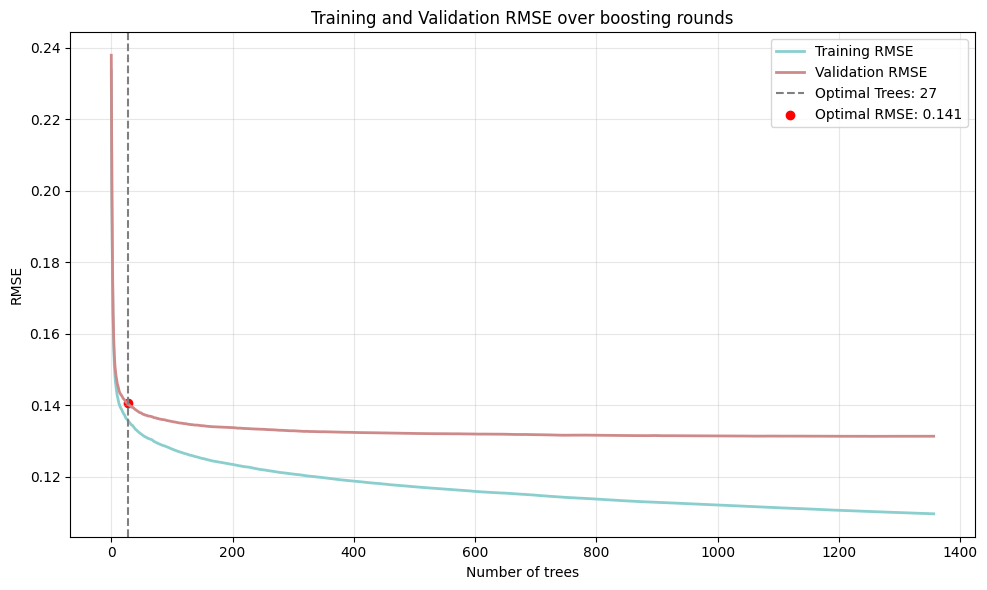

In [20]:
# Extract optimal iteration
optimal_trees = model.best_iteration
train_rmse = evals_result['train']['rmse']
eval_rmse = evals_result['eval']['rmse']

gain = 0.0001
# Convergence plot
def plot_convergence(train_rmse, eval_rmse, optimal_trees):
    # Check for stopping condition where RMSE decrease is not higher than gain
    for i in range(1, len(eval_rmse)):
        if abs(eval_rmse[i - 1] - eval_rmse[i]) < gain:
            print(f"Stopping early: RMSE decrease < 0.01 at tree {i}")
            optimal_trees = i
            break

    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse, label='Training RMSE', color='#8acece', linewidth=2)
    plt.plot(eval_rmse, label='Validation RMSE', color='#ce8a8a', linewidth=2)
    plt.axvline(optimal_trees, color='gray', linestyle='--', label=f"Optimal Trees: {optimal_trees}")
    plt.scatter(optimal_trees, eval_rmse[optimal_trees - 1], color='red', label=f"Optimal RMSE: {eval_rmse[optimal_trees - 1]:.3f}")
    plt.xlabel('Number of trees')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE over boosting rounds')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

plot_convergence(train_rmse, eval_rmse, optimal_trees)

In [22]:
# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae
    
# Compute predictions 
y_pred_train_flat = model.predict(dtrain) 
y_pred_test_flat = model.predict(dtest) 

# Compute and print evaluation metrics for train and test data
r2_train, rmse_train, mae_train = compute_metrics(y_train_flat, y_pred_train_flat)
r2_test, rmse_test, mae_test = compute_metrics(y_test_flat, y_pred_test_flat)

print("\nEvaluation Metrics:\n")
print(f"Training Data:\n R^2: {r2_train:.3f}, RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}")
print(f"Test Data:\n R^2: {r2_test:.3f}, RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}")


Evaluation Metrics:

Training Data:
 R^2: 0.858, RMSE: 0.110, MAE: 0.079
Test Data:
 R^2: 0.804, RMSE: 0.131, MAE: 0.098


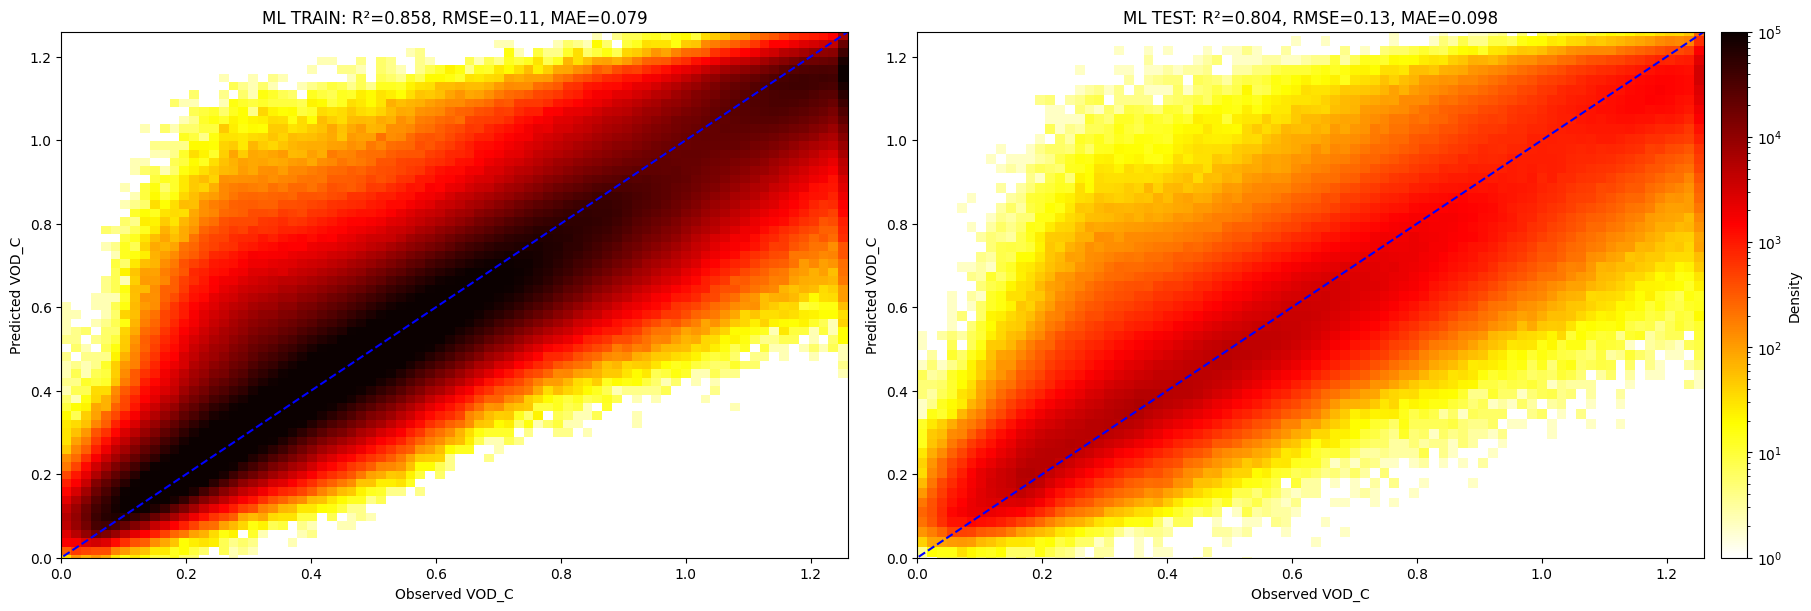

In [29]:
var_plot = target[0].upper()
vmin = 0
vmax = 1.26
vmax_density = 10000

def plot_frequency(y_train_flat, y_pred_train_flat, y_test_flat, y_pred_test_flat):
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6), constrained_layout=True)

    # Train set metrics
    train_title = f"ML TRAIN: R²={r2_train:.3f}, RMSE={rmse_train:.2f}, MAE={mae_train:.3f}"

    # Train set plot
    train_hist = ax[0].hist2d(
        y_train_flat, y_pred_train_flat,
        cmin=1, bins=80, norm=LogNorm(vmax=vmax_density), cmap="hot_r"
    )
    ax[0].set_title(train_title, fontsize=12)
    ax[0].plot(np.arange(-2, 5), np.arange(-2, 5), 'b', linestyle='--')  # Diagonal line
    ax[0].set_ylim([vmin, vmax])
    ax[0].set_xlim([vmin, vmax])
    ax[0].set_xlabel(f"Observed {var_plot}")
    ax[0].set_ylabel(f"Predicted {var_plot}")

    # Test set metrics
    test_title = f"ML TEST: R²={r2_test:.3f}, RMSE={rmse_test:.2f}, MAE={mae_test:.3f}"

    # Test set plot
    test_hist = ax[1].hist2d(
           y_test_flat, y_pred_test_flat,
        cmin=1, bins=80, norm=LogNorm(vmax=100000), cmap="hot_r"
    )
    ax[1].set_title(test_title, fontsize=12)
    ax[1].plot(np.arange(-2, 5), np.arange(-2, 5), 'b', linestyle='--')  # Diagonal line
    ax[1].set_ylim([vmin, vmax])
    ax[1].set_xlim([vmin, vmax])
    ax[1].set_xlabel(f"Observed {var_plot}")
    ax[1].set_ylabel(f"Predicted {var_plot}")

    # Shared colorbar for both subplots
    cbar = fig.colorbar(test_hist[3], ax=ax, orientation='vertical', fraction=0.02, pad=0.01)
    cbar.ax.set_ylabel('Density')

# Call frequency plot function
plot_frequency(y_train_flat, y_pred_train_flat, y_test_flat, y_pred_test_flat)

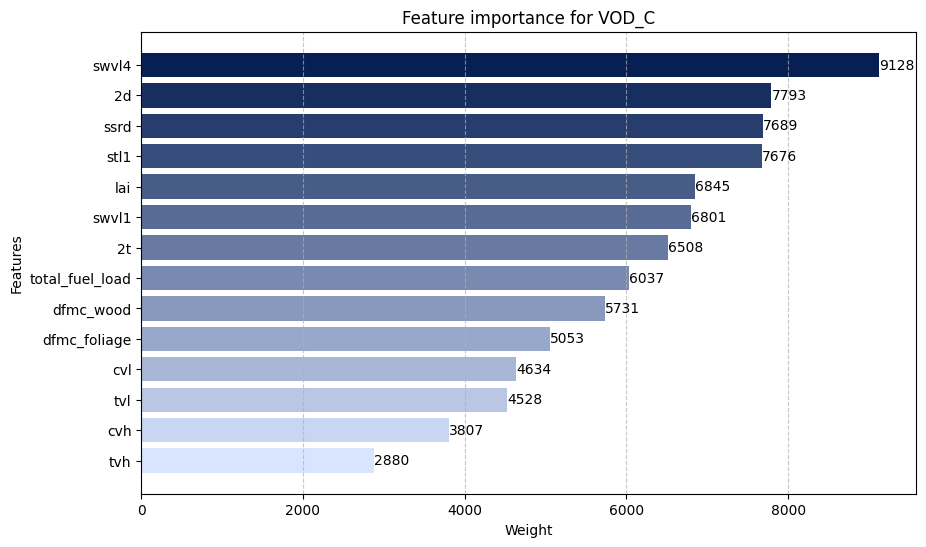

In [30]:
# Feature importance 
def plot_feature_importance(model, features):
    """
    Plots the feature importance for a trained XGBoost model.
    """
    # Extract feature importance scores
    importance_dict = model.get_score(importance_type='weight')  # Options: 'weight', 'gain', 'cover'

    # Convert to sorted lists
    sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_features, sorted_importances = zip(*sorted_items)

    # Define colors for the bars
    colors = [
        "#D9E5FF", "#C9D6F2", "#B9C7E5", "#A9B7D7", "#98A8CA",
        "#8899BD", "#788AB0", "#687AA2", "#586B95", "#485C88",
        "#374D7B", "#273D6D", "#172E60", "#071F53"
    ][::-1]

    # Normalize the importance for color mapping 
    norm = plt.Normalize(min(sorted_importances), max(sorted_importances))

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_features, sorted_importances, color=colors[:len(sorted_features)])

    # Invert y-axis to have the most important feature on top
    plt.gca().invert_yaxis()

    # Add value labels next to each bar
    for bar, importance in zip(bars, sorted_importances):
       plt.text(
            bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{importance:.0f}', va='center', fontsize=10, color='black'
        )

    # Plot annotations
    plt.xlabel('Weight', fontsize=10)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Feature importance for {var_plot}', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

# Call the function
plot_feature_importance(model, features)

Sampling 5000 rows from X_test_flat...
Initializing SHAP TreeExplainer...
Computing SHAP values for the sampled data...
Generating SHAP summary plot...


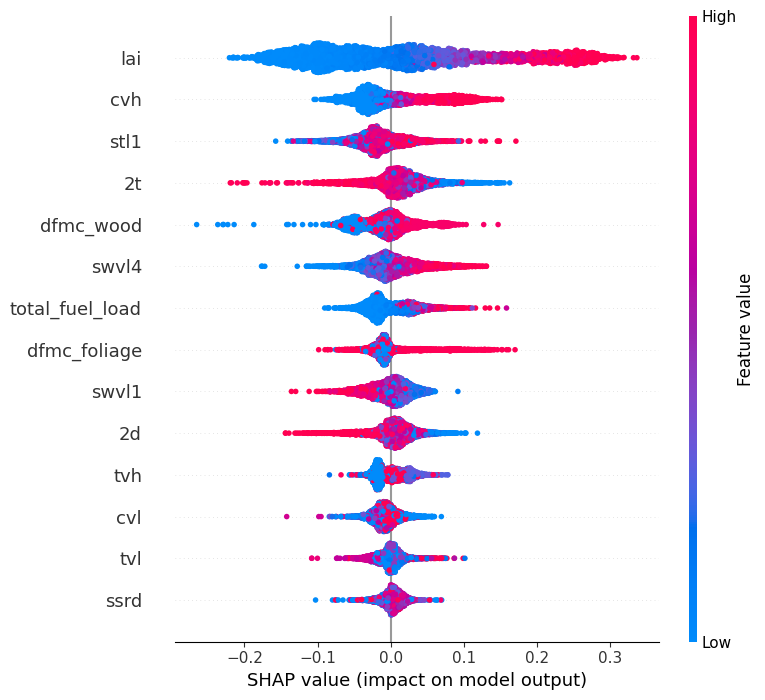

In [34]:
# SHAP values
def compute_shap_values_sampled(model, X_test, features, sample_size):
    """
    Computes SHAP values for a random sample of flattened test data and generates a summary plot.
    """
    # Sample the data
    n_samples = X_test.shape[0]
    if sample_size > n_samples:
        raise ValueError(f"Sample size {sample_size} exceeds available data ({n_samples}).")

    print(f"Sampling {sample_size} rows from X_test_flat...")
    sampled_indices = np.random.choice(n_samples, sample_size, replace=False)
    X_test_sample = X_test[sampled_indices]

    # Create DMatrix for the sample
    dtest_sample = xgb.DMatrix(X_test_sample, feature_names=features)

    # Compute SHAP values
    print("Initializing SHAP TreeExplainer...")
    explainer = shap.TreeExplainer(model)
    print("Computing SHAP values for the sampled data...")
    shap_values_sample = explainer.shap_values(dtest_sample)

    # Generate SHAP summary plot
    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values_sample, X_test_sample, feature_names=features, show=False)

# Call the function
compute_shap_values_sampled(
    model=model,
    X_test=X_test,  
    features=features,
    sample_size=5000  
)

<Axes: >

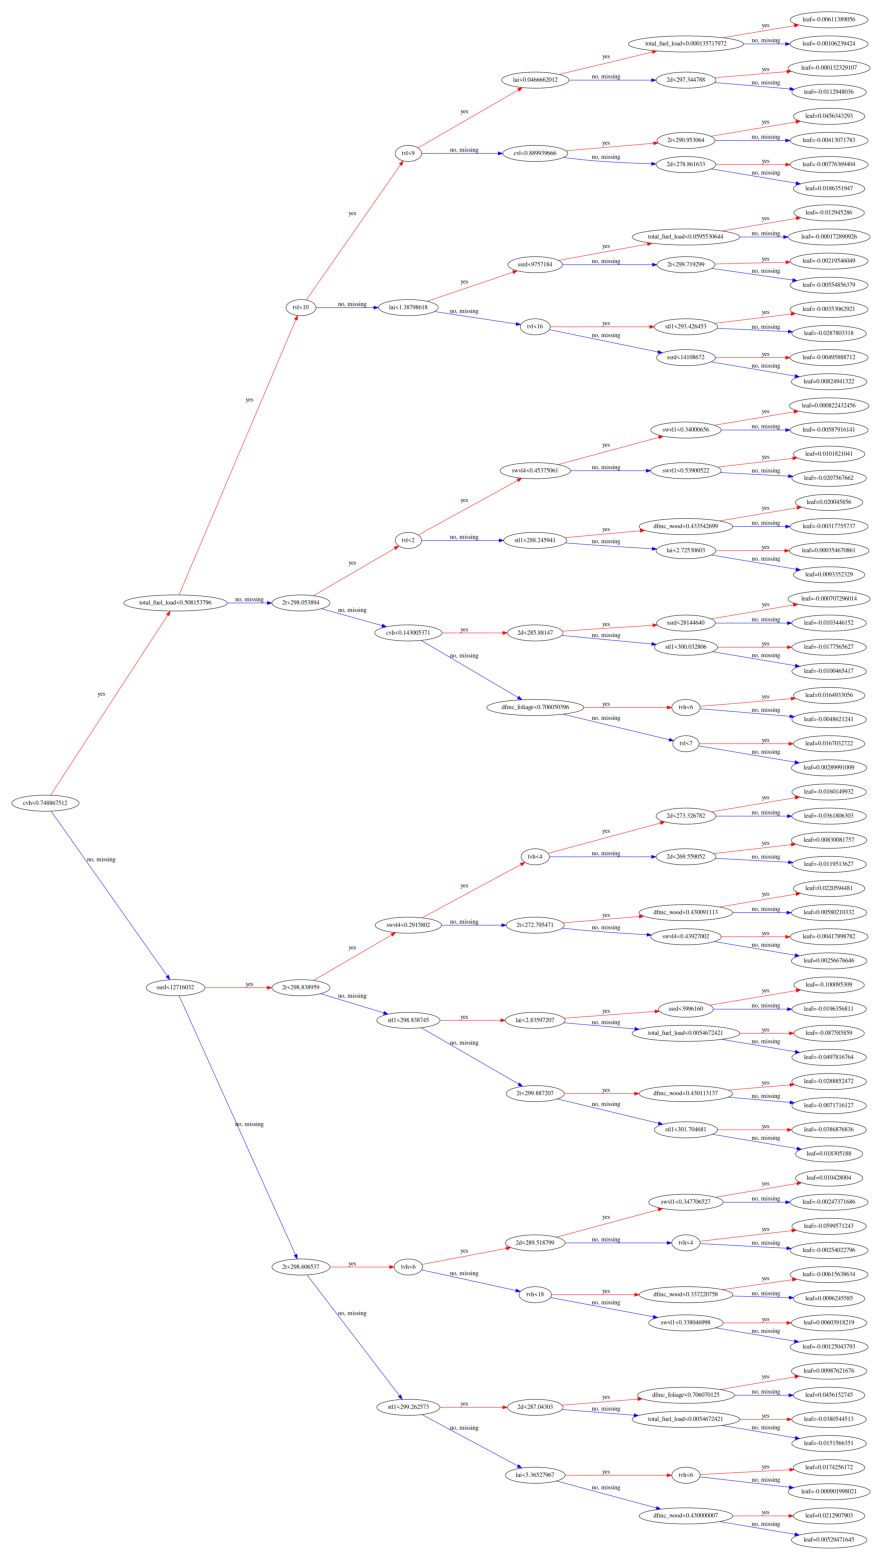

In [35]:
# View example of single decision tree from XGBoost
fig, ax = plt.subplots(figsize=(30,20))
xgb.plot_tree(model, num_trees=10, rankdir='LR', ax=ax)

In [42]:
# Plot one snapshot 
def plot_snapshots_with_norm_diff(
    snapshot_times, X_test_clean, y_test_flat, retained_spatial_indices_test,
    retained_time_mapping_test, ds_test, features, model, var_plot, max_snapshots):
    # Limit snapshots to max_snapshots
    snapshot_times = snapshot_times[:max_snapshots]
    print(f"Processing up to {len(snapshot_times)} snapshots...")

    for snapshot_time in snapshot_times:
        # Mask data for the snapshot
        snapshot_mask = retained_time_mapping_test == snapshot_time
        num_valid_rows = np.sum(snapshot_mask)
        if num_valid_rows == 0:
            print(f"No data found for snapshot time {snapshot_time}!")
            continue

        # Extract snapshot data
        X_test_snapshot = X_test_clean[snapshot_mask, :]  # Features for the snapshot
        y_test_snapshot = y_test_flat[snapshot_mask]  # Observed target values
        latitudes_snapshot = ds_test.latitudes.flatten()[retained_spatial_indices_test[snapshot_mask]]
        longitudes_snapshot = ds_test.longitudes.flatten()[retained_spatial_indices_test[snapshot_mask]]

        # Impute missing values in the snapshot
        nan_mask = np.isnan(X_test_snapshot)
        if nan_mask.any():
            col_means = np.nanmean(X_test_clean, axis=0)  # Compute column-wise means from clean dataset
            nan_indices = np.where(nan_mask)
            X_test_snapshot[nan_mask] = np.take(col_means, nan_indices[1])

        # Verify no NaN values remain
        assert not np.isnan(X_test_snapshot).any(), "Imputation failed: NaN values remain in X_test_snapshot."

        # Predict using XGBoost
        dmatrix_test = xgb.DMatrix(X_test_snapshot, feature_names=features)
        y_pred_snapshot = model.predict(dmatrix_test)

        # Compute normalized difference
        normalized_diff = (y_test_snapshot - y_pred_snapshot) / y_test_snapshot
        normalized_diff[np.isinf(normalized_diff) | np.isnan(normalized_diff)] = 0  # Handle NaNs or Infs
        
        # Plot observed, predicted, and norm diff
        projection = ccrs.PlateCarree()
        fig, ax = plt.subplots(nrows=3, figsize=[18, 18], subplot_kw={'projection': projection})

        for i, (data, title, cmap, vmin_val, vmax_val) in enumerate(
            zip(
                [y_test_snapshot, y_pred_snapshot, normalized_diff],
                ["Observed", "Predicted", "Normalised difference"],
                ['viridis', 'viridis', 'RdBu'],
                [vmin, vmin, -1.0],
                [vmax, vmax, 1.0]
            )
        ):
          # Add base map features
            ax[i].set_extent((-180, 180, -60, 90), crs=ccrs.PlateCarree())
            ax[i].add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
            ax[i].add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
            ax[i].coastlines(resolution='50m', linewidth=1, color='black', zorder=5)

            # Adjust gridlines
            gl = ax[i].gridlines(draw_labels=True, alpha=0.6, color='grey',
                                 linewidth=0.5, linestyle='--',
                                 x_inline=False, y_inline=False)
            gl.xlabel_style = {'size': 10, 'color': 'gray'}
            gl.ylabel_style = {'size': 10, 'color': 'gray'}

            # Scatter plot
            scatter = ax[i].scatter(
                longitudes_snapshot, latitudes_snapshot, c=data,
                cmap=cmap, vmin=vmin_val, vmax=vmax_val,
                transform=ccrs.PlateCarree(), s=1, rasterized=True, antialiased=False, zorder=3
            )
            ax[i].set_title(f"{title} {var_plot} ({snapshot_time})", fontsize=12)

            # Add colorbar
            cbar = fig.colorbar(scatter, ax=ax[i], orientation='vertical', fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel(title, fontsize=10)

        fig.tight_layout()

Processing up to 2 snapshots...


/dev/shm/_tmpdir_.masg.38637477/ipykernel_572819/939929433.py:38: RuntimeWarning: divide by zero encountered in divide
  normalized_diff = (y_test_snapshot - y_pred_snapshot) / y_test_snapshot
/dev/shm/_tmpdir_.masg.38637477/ipykernel_572819/939929433.py:38: RuntimeWarning: divide by zero encountered in divide
  normalized_diff = (y_test_snapshot - y_pred_snapshot) / y_test_snapshot


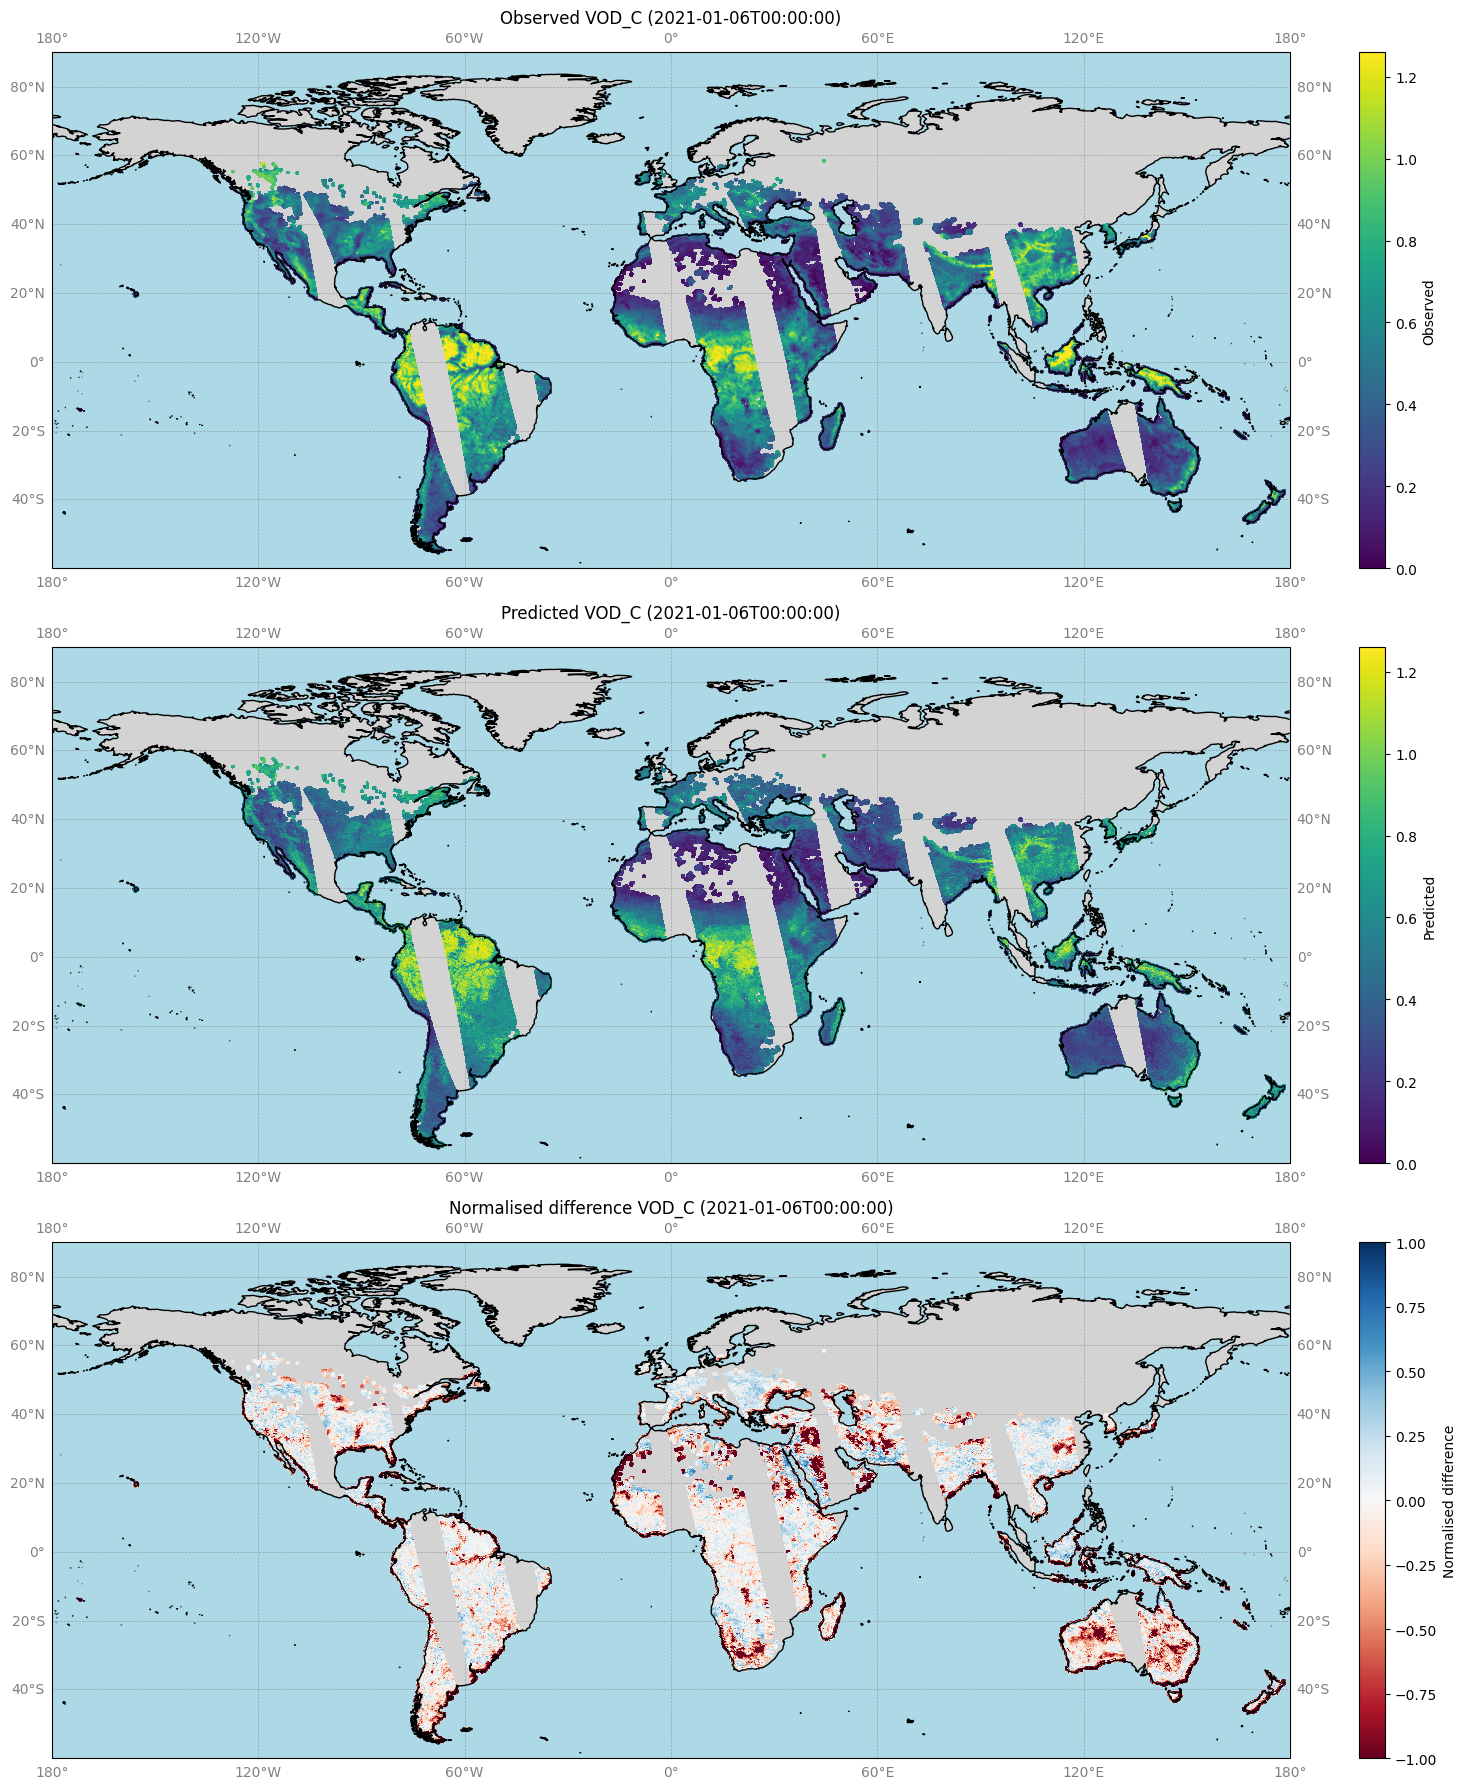

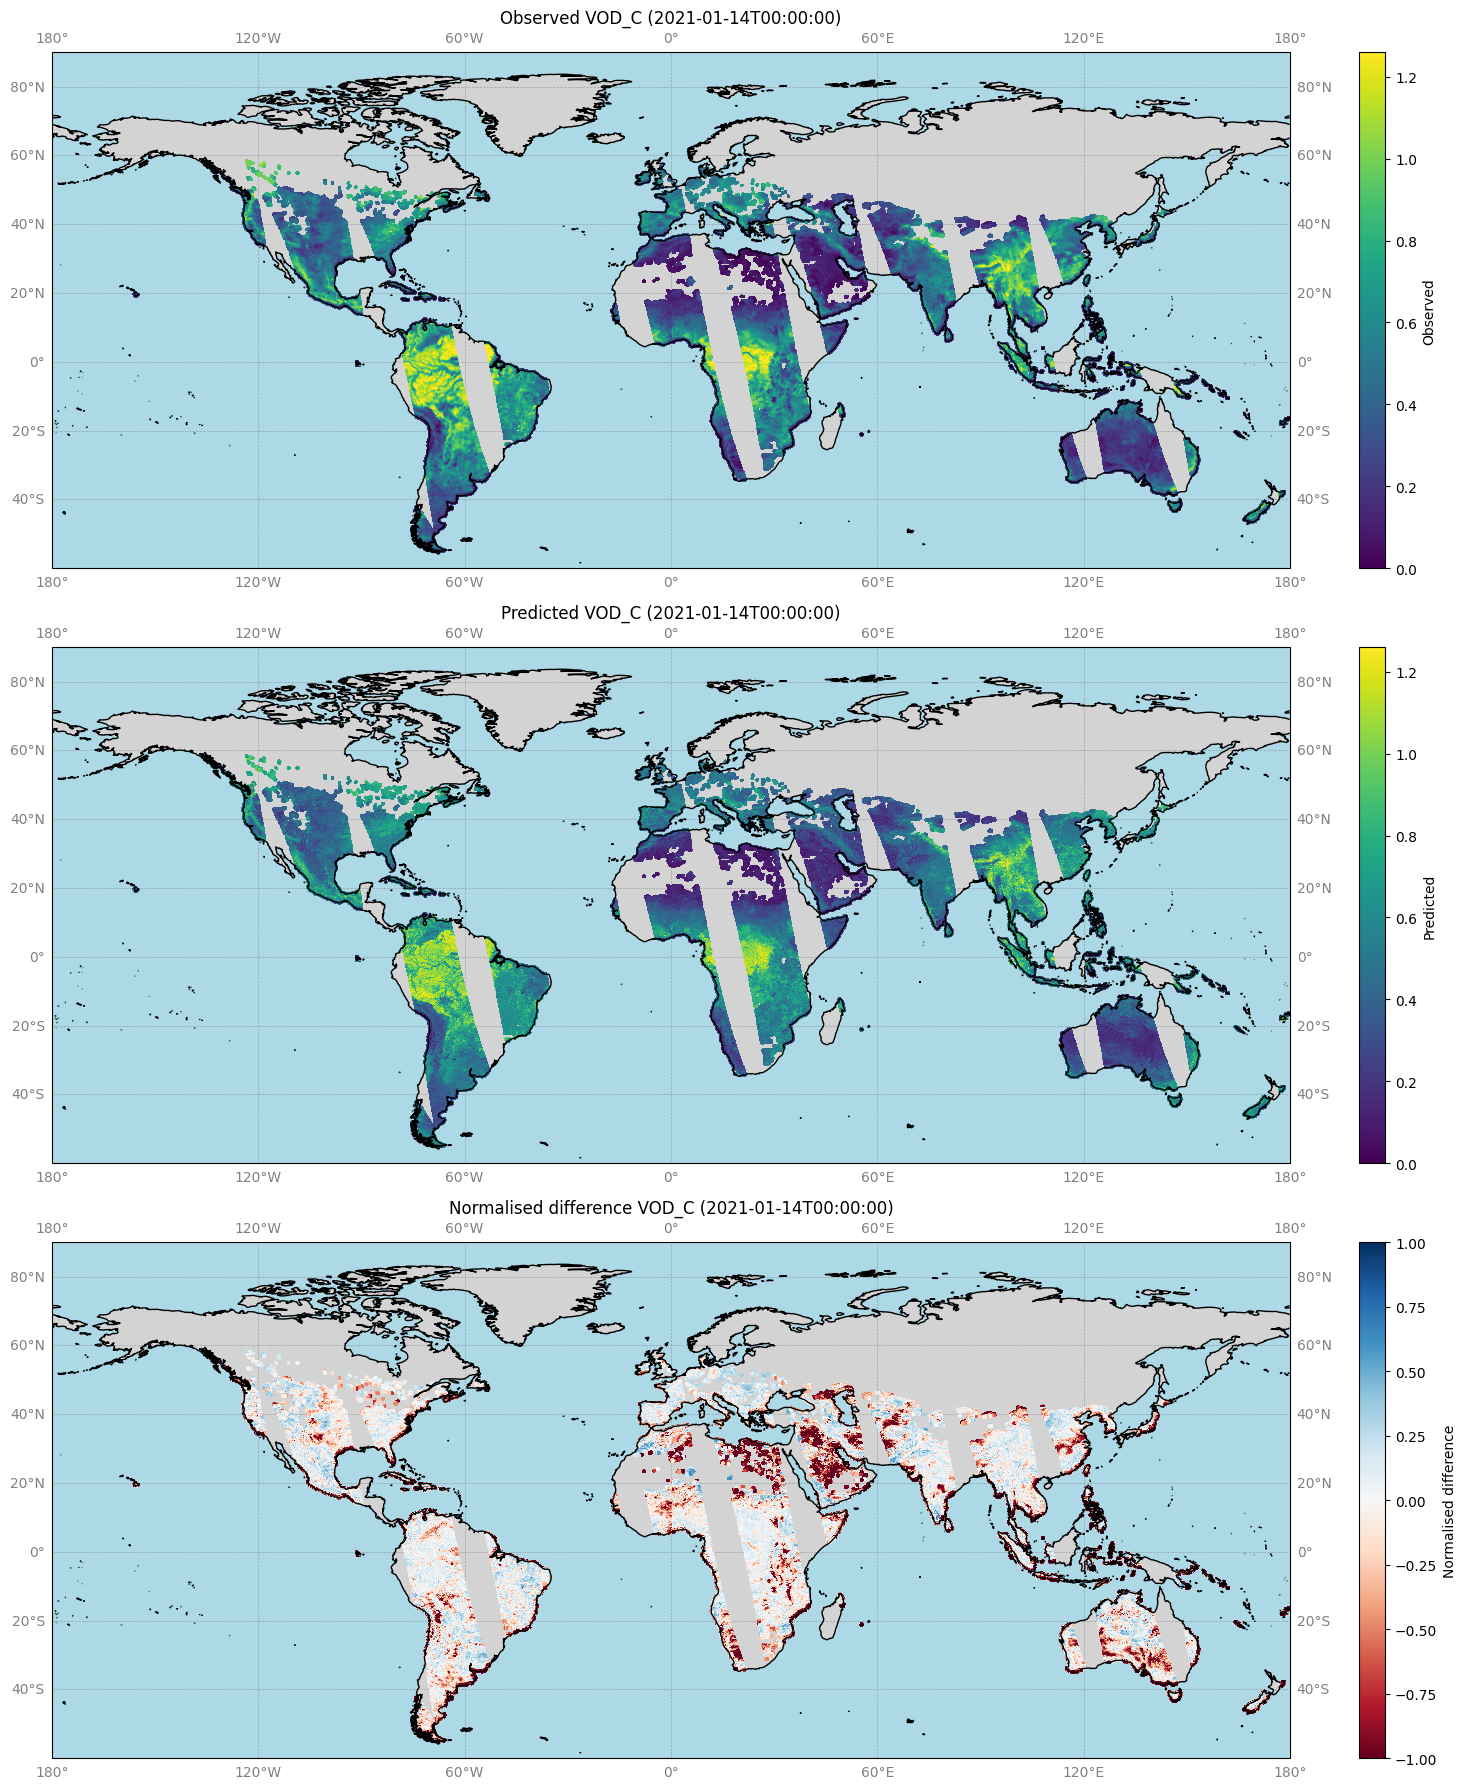

In [43]:
plot_snapshots_with_norm_diff(
    snapshot_times=ds_test.dates,
    X_test_clean=X_test,
    y_test_flat=y_test_flat,
    retained_spatial_indices_test=retained_spatial_indices_test,
    retained_time_mapping_test=retained_time_mapping_test,
    ds_test=ds_test,
    features=features,
    model=model,
    var_plot=var_plot,
    max_snapshots=2
)